In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist
import warnings

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})
warnings.simplefilter('ignore')

2024-05-09 10:54:03.673148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 10:54:05.614103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 3層NN

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255

train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

In [3]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size) # divmod(a,b):a/bの割り算の商とあまりを取得
    data_batched = np.split(data[:num_batches * batch_size], num_batches)
    if mod:
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

In [4]:
class SoftmaxEstimationModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

In [5]:
key, key1 = random.split(random.PRNGKey(0))
variables = SoftmaxEstimationModel().init(key1, train_images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring f

{'Dense_0': {'bias': (512,), 'kernel': (784, 512)},
 'Dense_1': {'bias': (10,), 'kernel': (512, 10)}}

In [6]:
state = train_state.TrainState.create(
    apply_fn = SoftmaxEstimationModel().apply,
    params = variables['params'],
    tx = optax.adam(learning_rate=0.001)
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


In [7]:
@jax.jit
def train_step(state, inputs, labels):
    # loss以外も返す場合はhas_aux=True
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params,
        state,
        inputs,
        labels
    )
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

In [8]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

In [9]:
def train_epoch(state, input_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

In [10]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size):
    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        # Train
        state, loss_train, acc_train = train_epoch(state, train_inputs_batched, train_labels_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Eval
        _, loss_test, acc_test = train_epoch(state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy {:.4f}'.format(epoch, loss_train, acc_train), flush=True, end='')
        print (' Test: Loss: {:.4f}, Accuracy {:.4f}'.format(loss_test, acc_test), flush=True)

    history = {'loss_train': loss_history_train,
           'acc_train': acc_history_train,
           'loss_test': loss_history_test,
           'acc_test': acc_history_test}

    return state, history

In [11]:
%%time
state, history = fit(state, train_images, train_labels, test_images, test_labels, epochs=16, batch_size=128)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


Epoch: 1, Loss: 0.3022, Accuracy 0.9158 Test: Loss: 0.1680, Accuracy 0.9480
Epoch: 2, Loss: 0.1249, Accuracy 0.9633 Test: Loss: 0.1139, Accuracy 0.9631
Epoch: 3, Loss: 0.0808, Accuracy 0.9763 Test: Loss: 0.0945, Accuracy 0.9701
Epoch: 4, Loss: 0.0568, Accuracy 0.9838 Test: Loss: 0.0791, Accuracy 0.9757
Epoch: 5, Loss: 0.0408, Accuracy 0.9887 Test: Loss: 0.0740, Accuracy 0.9770
Epoch: 6, Loss: 0.0296, Accuracy 0.9926 Test: Loss: 0.0739, Accuracy 0.9771
Epoch: 7, Loss: 0.0217, Accuracy 0.9952 Test: Loss: 0.0738, Accuracy 0.9771
Epoch: 8, Loss: 0.0157, Accuracy 0.9971 Test: Loss: 0.0724, Accuracy 0.9781
Epoch: 9, Loss: 0.0112, Accuracy 0.9983 Test: Loss: 0.0696, Accuracy 0.9786
Epoch: 10, Loss: 0.0083, Accuracy 0.9988 Test: Loss: 0.0697, Accuracy 0.9801
Epoch: 11, Loss: 0.0064, Accuracy 0.9992 Test: Loss: 0.0734, Accuracy 0.9791
Epoch: 12, Loss: 0.0082, Accuracy 0.9983 Test: Loss: 0.0763, Accuracy 0.9784
Epoch: 13, Loss: 0.0111, Accuracy 0.9967 Test: Loss: 0.1015, Accuracy 0.9755
Epoch: 1

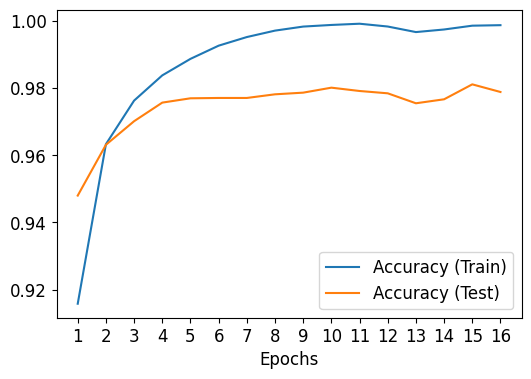

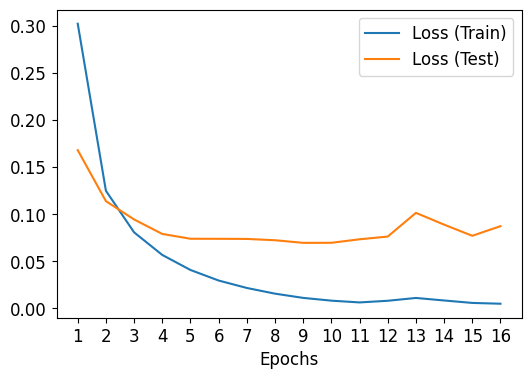

In [12]:

df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)